In [1]:
import utils as ut

#TODO: ALL - Create a better visualization of the adjacency matrix

# Read the files
eo = ut.read_file("../data/S072R01.edf")
ec = ut.read_file("../data/S072R02.edf")


######## 1.1

fs = 160 # Frequency of sampling, given by data
resolution = 100 # Resolution of model (s.t. each bin has 1Hz of width)
freq = 10 # Frequency of interest
density = 0.2 # Density of the graph desired


###PDC

# Fitting PDC models
eo_pdc = ut.fit_model(eo, fs, resolution, "pdc", freq)
ec_pdc = ut.fit_model(ec, fs, resolution, "pdc", freq)

# Adjacency Matrices for 20% density networks
ut.adjacency_matrix(eo_pdc, ut.find_threshold(eo_pdc,density), "eo_pdc_20")
ut.adjacency_matrix(ec_pdc, ut.find_threshold(ec_pdc,density), "ec_pdc_20")



######## 1.2


# Fitting DTF models
eo_dtf = ut.fit_model(eo, fs, resolution, "dtf", freq)
ec_dtf = ut.fit_model(ec, fs, resolution, "dtf", freq)

# Adjacency Matrices for 20% density networks
ut.adjacency_matrix(eo_dtf, ut.find_threshold(eo_dtf,density), "eo_dtf_20")
ut.adjacency_matrix(ec_dtf, ut.find_threshold(ec_dtf,density), "ec_dtf_20")




######## 1.3

densities = [0.01,0.05,0.1,0.3,0.5] #Different thresholds

#Names for files
eo_pdc_names = ["eo_pdc_01", "eo_pdc_05", "eo_pdc_10", "eo_pdc_30", "eo_pdc_50"]
ec_pdc_names = ["ec_pdc_01", "ec_pdc_05", "ec_pdc_10", "ec_pdc_30", "ec_pdc_50"]
eo_dtf_names = ["eo_dtf_01", "eo_dtf_05", "eo_dtf_10", "eo_dtf_30", "eo_dtf_50"]
ec_dtf_names = ["ec_dtf_01", "ec_dtf_05", "ec_dtf_10", "ec_dtf_30", "ec_dtf_50"]


### PDC Networks

eo_pdc_networks = list(map(lambda x: ut.adjacency_matrix(eo_pdc, ut.find_threshold(eo_pdc,x[0]), x[1]), zip(densities,eo_pdc_names)))
ec_pdc_networks = list(map(lambda x: ut.adjacency_matrix(ec_pdc, ut.find_threshold(ec_pdc,x[0]), x[1]), zip(densities,ec_pdc_names)))


### DTF Networks

eo_dtf_networks = list(map(lambda x: ut.adjacency_matrix(eo_dtf, ut.find_threshold(eo_dtf,x[0]), x[1]), zip(densities,eo_dtf_names)))
ec_dtf_networks = list(map(lambda x: ut.adjacency_matrix(ec_dtf, ut.find_threshold(ec_dtf,x[0]), x[1]), zip(densities,ec_dtf_names)))


######## 1.4

#Subset of channels
channels = ["Fp1", "Fp2", "F7", "F3", "Fz", "F4", "F8", "T7", "C3", "Cz", "C4", "T8", "P7", "P3", "Pz", "P4", "P8", "O1", "O2"]

# Reading the subset of channels from files
small_eo = ut.read_file("../data/S072R01.edf", channels = channels)
small_ec = ut.read_file("../data/S072R02.edf", channels = channels)

# Adjacency Matrices with Bootstrap validation
ut.adjacency_matrix(ut.fit_model(small_eo, fs, resolution, "pdc", freq = freq, boot = True), 0.05, "small_eo_pdc")
ut.adjacency_matrix(ut.fit_model(small_ec, fs, resolution, "pdc", freq = freq, boot = True), 0.05, "small_ec_pdc")


######## 1.5

# Save a png of the network for each network
for network in [elem[:-4] for elem in ut.get_networks()]:
    ut.viz_graph(network)


######## 1.6

# Choosing an alternative frequency
alternative_frequency = 50

###PDC

# Fitting models
alt_eo_pdc = ut.fit_model(eo, fs, resolution, "pdc", alternative_frequency)
alt_ec_pdc = ut.fit_model(ec, fs, resolution, "pdc", alternative_frequency)

# Adjacency Matrices
ut.adjacency_matrix(alt_eo_pdc, ut.find_threshold(alt_eo_pdc,density), "alt_eo_pdc_20")
ut.adjacency_matrix(alt_ec_pdc, ut.find_threshold(alt_ec_pdc,density), "alt_ec_pdc_20")



In [4]:
import numpy as np
import os
import pyedflib
import connectivipy
import matplotlib.pyplot as plt
import networkx as nx

In [27]:
def get_labels_nodes(number_of_nodes = 64):
    if number_of_nodes == 64:
        return ['Fc5', 'Fc3', 'Fc1', 'Fcz', 'Fc2', 'Fc4', 'Fc6', 'C5', 'C3', 'C1',
                'Cz', 'C2', 'C4', 'C6', 'Cp5', 'Cp3', 'Cp1', 'Cpz', 'Cp2', 'Cp4',
                'Cp6', 'Fp1', 'Fpz', 'Fp2', 'Af7', 'Af3', 'Afz', 'Af4', 'Af8', 'F7',
                'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'Ft7', 'Ft8', 'T7',
                'T8', 'T9', 'T10', 'Tp7', 'Tp8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2',
                'P4', 'P6', 'P8', 'Po7', 'Po3', 'Poz', 'Po4', 'Po8', 'O1', 'Oz', 'O2', 'Iz']
    else:
        return ["Fp1", "Fp2", "F7", "F3", "Fz", "F4", "F8", "T7", "C3", "Cz",
                "C4", "T8", "P7", "P3", "Pz", "P4", "P8", "O1", "O2"]

def get_coordinates():
    
    with open("../data/channel_locations.txt") as f:
        
        coord = {}
        
        channels = [row.split("        ") for row in f.readlines()[1:]]

        for elem in channels:
            coord[elem[1]] = (float(elem[2]), float(elem[3]))
        
        return coord

def viz_graph(file):
    
    adj = np.load("../part_1/results/npy/"+"ec_dtf_20"+".npy")
    G = nx.from_numpy_matrix(adj, create_using = nx.DiGraph())
    G = nx.relabel_nodes(G, dict(enumerate(get_labels_nodes(adj.shape[0]))))

    #

    # color
    for node in G.nodes():
        if node in get_labels_nodes(number_of_nodes = 19):
            color = 'red'
        else:
            color = '#b9c1d1'
        G.node[node]['color'] = color


    plt.figure(num=None, figsize=(15,15), dpi=50)
    
    nx.draw(G, node_shape= 'o', with_labels = True, pos = get_coordinates(), node_size = 2000, 
            node_color=list(nx.get_node_attributes(G,'color').values()), font_size=18)
    plt.title(file, fontsize=25) 

    
    plt.show()
    #plt.savefig("results/png/networks/"+file+".png", bbox_inches='tight')
    plt.close()
    return

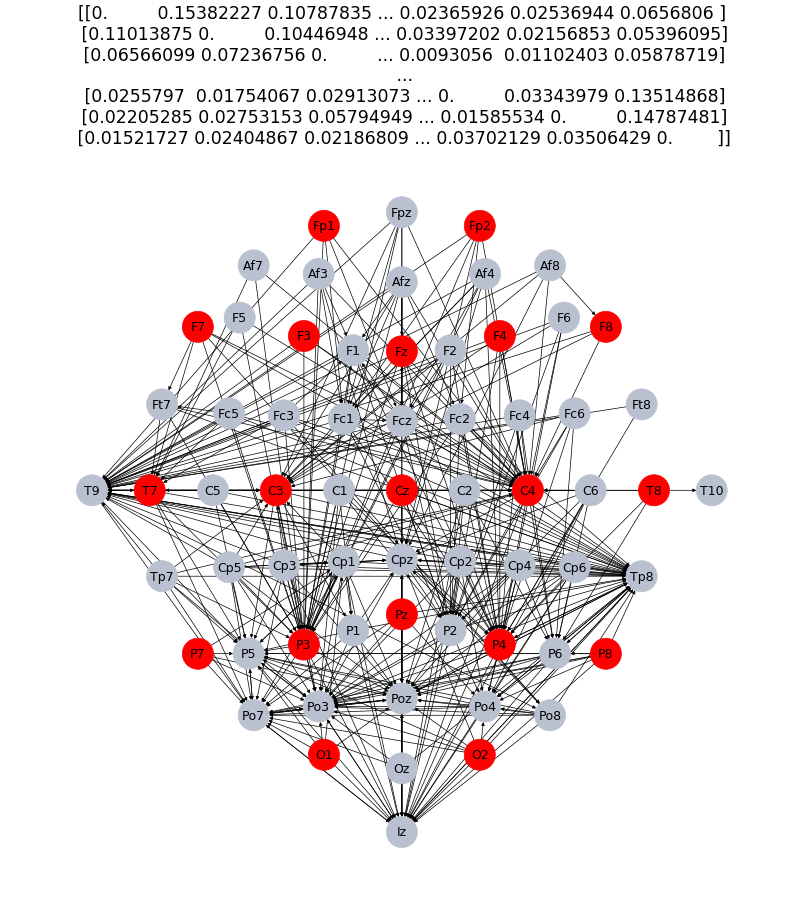

In [28]:
viz_graph(eo_pdc)

In [31]:
list(G.nodes)[0] in get_labels_nodes(64)

True

In [2]:
eo_pdc

array([[0.        , 0.15382227, 0.10787835, ..., 0.02365926, 0.02536944,
        0.0656806 ],
       [0.11013875, 0.        , 0.10446948, ..., 0.03397202, 0.02156853,
        0.05396095],
       [0.06566099, 0.07236756, 0.        , ..., 0.0093056 , 0.01102403,
        0.05878719],
       ...,
       [0.0255797 , 0.01754067, 0.02913073, ..., 0.        , 0.03343979,
        0.13514868],
       [0.02205285, 0.02753153, 0.05794949, ..., 0.01585534, 0.        ,
        0.14787481],
       [0.01521727, 0.02404867, 0.02186809, ..., 0.03702129, 0.03506429,
        0.        ]])